# Assignment 3

We have information about several auctions at different times. The goal of the assignment is to predict whether a certain auction will be succesfull or not and then optimize a certain auction in order to get the most profit. The assignment consists of the following steps:  
  
1) *Descriptive Analysis*  
Here we do some basic exploratory analysis in order to get a feeling for the data and what we can do with it. We are allowed to also use correlation, plots and some simple inferences. Moreover, this is a nice way to start thinking about creating new features if neccesary.   
  
2) *Prediction Model*  
The goal is to build a prediction model that can either classify or predict the performance of a new auction. We are free to choose either classification or prediction as long as we are accurate since the model is used in step 3. Moreover, it should also be a relatively fast method in order to use it in our optimization in step 3.   
  
3) *Optimization*  
Given a new auction, optimize its features in such a way that you will maximize the final output. In other words, optimize the different variables and their values in a way to get the most money out of your auction. For example, if you have an item/lot that you expect will be worth 200 euros, then setting the starting bid at 50 euros or 100 euros might make a big difference on the end price. Each time we change a value, we check with our prediction model whether that change is a good one or not in order to eventually get the best "lay-out" of an auction. 

**Features**  
We have the following features in the dataset:  
* **Multiplier**  This is defined as (Winning Bid / Estimated Value)
* **LotNr** An items number, the lower the number the earlier the item is shown on the site
* **Allocate** Whether the seller of the lot has set a price which he want as minimum for the lot 
* **EstValue**: estimated value of the lot (by auction experts)
* **StartPrice**: starting bidding price of the lot
* **Followers**: nr. of people following the lot
* **Bank, Dealer, Liquidator, Volunteer**: type of sales
* **LotsSale**: amount of lots of one sale
* **LotsCtgry**: amount of lots within a sale with the same category
* **Forced**: whether a sale is forced or not (due to bankruptcy)
* **SP.EV**: starting price/estimated value
* **Duration**: duration of auctions in hours on a lot
* **Morning, Evening, Afternoon**: last bid on the lot 

## <a name="table">Table of Contents</a> 

1. [Functions](#functions)

2. [Preprocessing](#preprocessing)

3. [Exploration](#exploration)

4. [Visualization](#visual)  

    4.1 [Plots](#plots)  
    
    4.2 [Correlations](#correlation)  
    
5. [Feature Engineering](#engineering)  

    5.1 [Outlier Removal](#outliers)  
    
    5.2 [Resolving Skewedness](#skewedness)  
    
6. [Feature Importance](#importance)  

    6.1 [Decision Tree](#importancetree)  
    
    6.2 [Random Forest](#importanceforest)  
    
    6.3 [Feature Selection](#selection)  
    
7. [Prediction](#prediction)  

    7.1 [Classification with K-Fold](#resultclassifiers)  
    
    7.2 [Classification with LOO](#loo)  
    
    7.3 [Voting Classifier with LOO](#voting)  
    
    7.4 [Regression with K-Fold](#regression)  
    
8. [Grid Search](#grid)  

    8.1 [Classification](#gridclassification)  

    8.2 [Regression](#gridregression)  

9. [Optimization - Description](#optimization)

10. [Optimization - Regression](#regressionoptimization)

11. [Optimization - Classification](#optimizationfull)

    11.1 [Genetic Algorithm](#geneticalgorithm)  

    11.2 [Heuristic](#heuristic)  

    11.3 [Validation](#validation)  

### <a name="functions">1. Functions</a> 
[Back to Table of Contents](#table)

In [1]:
import math
import graphviz 
import warnings
import random

import pandas                  as pd
import numpy                   as np
import seaborn                 as sns
import matplotlib.pyplot       as plt

from deap                      import base
from deap                      import creator
from deap                      import tools

from scipy.stats               import skew
from sklearn.tree              import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.svm               import SVC
from sklearn.ensemble          import RandomForestRegressor,VotingClassifier,AdaBoostClassifier, \
                                      GradientBoostingClassifier, RandomForestClassifier, \
                                      GradientBoostingRegressor
from sklearn.naive_bayes       import GaussianNB
from sklearn.linear_model      import LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge      import KernelRidge

from xgboost                   import XGBClassifier, XGBRegressor
from catboost                  import CatBoostClassifier, CatBoostRegressor
from lightgbm                  import LGBMClassifier, LGBMRegressor

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection   import StratifiedShuffleSplit, train_test_split, GridSearchCV,\
                                      cross_val_score
from sklearn.metrics           import accuracy_score, log_loss, mean_squared_error
from sklearn.preprocessing     import StandardScaler, MinMaxScaler

from mlxtend.classifier        import StackingClassifier, StackingCVClassifier

%matplotlib inline
warnings.simplefilter("ignore", category=PendingDeprecationWarning) # LightGBM
warnings.simplefilter("ignore", category=DeprecationWarning)        # LightGBM
warnings.simplefilter("ignore", category=UserWarning)               # LightGBM

def preprocess_data(file_1_location = 'data2014.csv', file_2_location = 'data2015.csv'):
    """ Loading and preprocessing the data
    
    Parameters:
    -----------
        file_1_location (str): The location of the first csv file
        file_2_location (str): The location of the first csv file
        
    Returns:
    --------
        df (dataframe): Preprocessed dataframe
    
    """
    
    # Load in Data
    df_2014 = pd.read_csv(file_1_location)
    df_2015 = pd.read_csv(file_2_location)

    # Merge two files
    df_2014['Year'] = 2014
    df_2015['Year'] = 2015
    df = df_2014.append(df_2015)
    df = df.set_index(np.arange(len(df)))

    # Extract part of day as a single variable and remove columns
    df['Part_of_Day'] = df.apply(lambda row: get_part_of_day(row), axis = 1)
    df['multiplier_binary'] = df.apply(lambda row: get_bin_multiplier(row['multiplier']), axis = 1)

    df = df.drop(['Morning', 'Afternoon', 'Evening'], 1)

    # Since we have the number of lots in a category, we can also say that each number of lots in a category 
    # is associated with a single category
    # This is an assumption that might not hold, but it does give more information about having several categories
    categories = {value: index+1 for index, value in enumerate(list(df['LotsCtgry'].unique()))}
    df['Category'] = df.apply(lambda row: categories[row['LotsCtgry']], axis = 1)

    # Test for consecutive rows
    test_consecutive_sale(df)

    # Create new column with sale number as the number of lots in a sale can be used as a proxy to which sale a lot belongs
    sale_number = {value: index+1 for index, value in enumerate(list(df['LotsSale'].unique()))}
    df['Sale_nr'] = df.apply(lambda row: sale_number[row['LotsSale']], axis = 1)

    # # Get number of categories in a sale
    df = get_categories_per_sale(df)
    
    # Ordered lot numbers by category
    ctgry_lot_nr_map = {(sales_nr,ctgry_nr,lot_nr): idx + 1 
                        for (sales_nr,ctgry_nr),lot_nr_list 
                            in df.groupby(['Sale_nr','Category']).LotNr.unique().items()
                        for idx, lot_nr in enumerate(lot_nr_list)}

    df['CtgryLotNr'] = list(zip(*[df.Sale_nr,df.Category,df.LotNr]))
    df['CtgryLotNr'] = df['CtgryLotNr'].map(ctgry_lot_nr_map)

    # Binarize Year
    year_map={2014:0,2015:1}
    df.Year = df.Year.map(year_map)
    
    # Create winning bid and the difference between winning bid and est. value
    df['WinningBid'] = df.apply(lambda row: row['EstValue'] * row['multiplier'], axis = 1)
    df['ResultDifference'] = df.apply(lambda row: row['EstValue'] * row['multiplier'] - 
                                      row['EstValue'], axis = 1)
    
    # Create 3 classes
    df['multiplier_three'] = df.apply(lambda row: three_classes(row), axis = 1)
    
    return df

def get_part_of_day(row):
    if row['Morning'] == 1:
        return 0
    elif row['Afternoon'] == 1:
        return 1
    elif row['Evening'] == 1:
        return 2
    else:
        return 'Error!'
    
def get_bin_multiplier(row):
    if row < 1:
        return 0
    elif row >= 1:
        return 1
    else:
        return 'Error'
    
def test_consecutive_sale(df):
    """ We want to know if the number of lots in a sale can be used
        to indicate whether it belongs to a certain sale. This function
        checks whether a consecutive series of LotsSale belong to each
        other by keeping a set in which we store the LotsSale values
        and check whether a new series of LotsSale has the same amount as
        a series we have seen previously. If it doesn't return an error, 
        we can use the column "LotsSale" as a proxy for the lotnumber
    """
    consecutive_check = set()
    previous = ''

    for i in df['LotsSale']:
        if len(consecutive_check) == 0:
            consecutive_check.update([i])
            previous = i

        if i == previous:
            continue
        else:
            if i in consecutive_check:
                print('Problem!')
                break
            else:
                consecutive_check.update([i])
                previous = i
    
def get_categories_per_sale(df):
    """ Count for each sale how many categories there are in it
    """
    test = df.groupby(by = ['Sale_nr', 'Category']).count().reset_index()
    df['Categories_per_sale'] = 0
    
    for i in df['Sale_nr'].unique():
        df.loc[df['Sale_nr'] == i, 'Categories_per_sale'] = len(test[test['Sale_nr'] == i]['Category'].unique())
        
    return df

def correlation_matrix(df):
    """ Shows a correlation matrix
    
    Parameters:
    -----------
        df (dataframe): Insert a dataframe with only the
                        columns that you want to visualize
    """
    sns.set(style="white")

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    sns.heatmap(corr, mask=mask,cmap="RdBu_r", linewidths=.5, cbar_kws={"shrink": .5});

def scatter_plot(df, x, y, figsize = (10, 5), xlabel=None, ylabel=None, title=None):
    """ Plots a scatterplot
    
    Parameters:
    -----------
        df (dataframe): Data to be plotted
        x (str): Name of column to be plotted
        y (str): Name of column to be plotted
        figsize (tup): Tuple of size 
        xlabel (str): Label x axis
        ylabel (str): Label y axis
        title (str): Title 
    """
    
    if not xlabel:
        xlabel = x
    if not ylabel:
        ylabel = y
    if not title:
        title = x + ' vs. ' + y
    
    plt.figure(figsize=figsize)
    xseries = df[x]
    yseries = df[y]
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(xseries,yseries, 'ro')
    plt.show()
    
def multiple_scatter_plots(df, to_plot, figsize=(10, 5), markersize=2,  max_row=2):
    """ Plots a scatterplot
    
    Parameters:
    -----------
        df (dataframe): Data to be plotted
        to_plot (list of tuples): Each tuples contains the column name of what you
                                  want to plot on the x and y axis respectively
        figsize (tup): Width and length of figures
        marketsize (int): Size of dots
        max_row (int): Number of plots per row
        
    """
    # Initialize values and create figure
    number_of_plots = len(to_plot)
    max_column = math.ceil(number_of_plots / max_row)
    fig, axs = plt.subplots(nrows=max_row, ncols=max_column, figsize=figsize)
        
    # Flatten list if possible
    try:
        axs = [item for sublist in axs for item in sublist]
    except:
        pass
        
    # Plot subplots
    for i in range(len(to_plot)):
        x = to_plot[i][0]
        y = to_plot[i][1]
        axs[i].plot(df[x], df[y], 'ro', markersize=markersize)
        axs[i].set_xlabel(x)
        axs[i].set_ylabel(y)
        axs[i].set_title(x + ' vs. ' + y)
        
    # Remove plots that are empty
    empty_plots = abs(number_of_plots - (max_column * max_row))
    if empty_plots > 0:
        for i in range(1, empty_plots + 1, 1):
            axs[-1].remove()
    
    plt.tight_layout(pad=2, h_pad=5)
    plt.show()
    
def plot_feature_importance(dataset, X, y):
    """ Plot the importance of features in X
    
    Parameters:
    -----------
        dataset (type): Dataset only containing relevant columns for X and y
        X (numpy array): Matrix of features
        y (numpy array): Target feature
        
    """
    
    # Create random forest classifier
    forest = RandomForestClassifier(n_estimators=250, random_state=42)
    forest.fit(X, y)

    # Calculate the relative importances of reatures
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure(figsize=(10, 4))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), dataset.columns[indices], rotation=70)
    plt.xlim([-1, X.shape[1]])
    plt.ylim([0, 0.4])
    plt.show()
    
def plot_decision_tree(dataset, X, y, max_depth=3):
    """ Plot decision tree to gain insight to feature importances
    
    Parameters:
    -----------
        dataset (type): Dataset only containing relevant columns for X and y
        X (numpy array): Matrix of features
        y (numpy array): Target feature
        max_depth (int): Depth of the decision tree
    
    """

    dtree=DecisionTreeClassifier(max_depth=max_depth)
    dtree.fit(X,y)

    dot_data = export_graphviz(dtree, out_file=None, 
                             feature_names=dataset.columns[:-1],  
                             class_names=["0", "1"],  
                             filled=True, rounded=True,  
                             special_characters=True) 
    graph = graphviz.Source(dot_data) 
    return graph

def cv_multiple_classifiers(X, y, classifiers = [RandomForestClassifier()], n_splits = 5, 
                            print_process = False):
    """
    
    Parameters:
    -----------
        X (numpy array): Matrix of features
        y (numpy array): Target feature
        n_splits (int): Number of splits for cross validation
        
    Returns:
    --------
        log (dataframe): Dataframe of the results
    
    """
    
    # Dataframe to track results
    log_cols = ["Classifier", "Accuracy"]
    log = pd.DataFrame(columns=log_cols)
    acc_dict = {name.__class__.__name__: 0 for name in classifiers}

    # Method of cross validation
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=42)
    fold = 1

    # Cross-validation for each classifier 
    for train_index, test_index in sss.split(X, y):
        if print_process:
            print('Fold {}'.format(fold))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        for clf in classifiers:
            name = clf.__class__.__name__
            clf.fit(X_train, y_train)
            train_predictions = clf.predict(X_test)
            acc = accuracy_score(y_test, train_predictions)
            acc_dict[name] += acc

        fold += 1

    # Average out accuracies over number of splits
    for clf in acc_dict:
        acc_dict[clf] = acc_dict[clf] / n_splits
        log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
        log = log.append(log_entry)

    # Plot results
    plt.xlabel('Accuracy')
    plt.title('Classifier Accuracy')
    sns.set_color_codes("muted")
    sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
    
    return log

def select_features(df, features = [], target = 'multiplier_binary'):
    """
    
    Parameters:
    -----------
        df (dataframe): Dataframe that you want to select features from
        features (list): List of the names (str) of the features you want
                         to extract as your X feature matrix
        target (str): The column name of the feature that you want to extract
        
    Returns:
    --------
        dataset (dataframe): Dataframe containig the features and target variables
        X (numpy matrix): Numpy matrix of feature values
        y (numpy array): Numpy array of the target values
    
    """
    
    # Select a standard set of features if no other are given
    if len(features) == 0:
        features = ['LotNr', 'Allocate', 'EstValue', 'StartPrice','Followers', 'Bank', 'Dealer', 
                    'Liquidator', 'Volunteer', 'LotsSale','LotsCtgry', 'Forced','SP.EV','Duration', 
                    'Year', 'Category', 'Sale_nr', 'Categories_per_sale']
    features.append(target)
    dataset = df[features]

    # Get X and y matrices
    X = dataset.iloc[:, list(range(len(dataset.columns)-1))].values
    y = dataset.iloc[:, -1].values
    
    return dataset, X, y

def loo_cv(dataset, clf=RandomForestClassifier(n_estimators=100), adjust_folds=True):
    """ Leave one-out cross validation
    
    An implementation of leave one-out cross validation in which the folds
    are determined by the sale number as we want to predict the multiplier of
    sales we have not previously seen. Thereby creating an average accuracy score
    that better represents reality. Folds in which the y_test shows very little
    rows are removed as those are likely outliers. 
    
    Parameters:
    -----------
        dataset (dataframe):   Dataframe with only the features used
                               in the classification task including the target.
        clf (classifier):      Classifier to be used for the Leave-one out 
                               cross validation
        
    Returns:
    --------
        results (list):      List of accuracies per fold
        info_folds (dict):   Dictionary of lengths of y_test per fold with the intent
                             to remove folds that with less than 50 rows
    """
    
    nr_folds = len(dataset['Sale_nr'].unique())
    info_folds = {fold: '' for fold in range(1, nr_folds+1)}
    results = []

    for sale_nr in range(1, nr_folds+1):
        X_train = dataset[dataset['Sale_nr']!= sale_nr].iloc[:,0:-1].values
        X_test = dataset[dataset['Sale_nr']== sale_nr].iloc[:,0:-1].values

        y_train = dataset[dataset['Sale_nr']!= sale_nr].iloc[:,-1].values
        y_test = dataset[dataset['Sale_nr']== sale_nr].iloc[:,-1].values

        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)

        results.append(acc)
        info_folds[sale_nr] = len(y_test)
        
    if adjust_folds:
        folds_to_remove = [fold[0]-1 for fold in info_folds.items() if fold[1]<50]
        results = [value for index, value in enumerate(results) if index not in folds_to_remove]
        for fold in folds_to_remove:
            del info_folds[fold+1]
    
    return results, info_folds

def three_classes(row):
    """ Create 3 classes of the multiplier variable:
        0 for multiplier < 1
        1 for multiplier between 1 and 2
        2 for multiplier larger than 2
    """
    if row['multiplier'] < 1:
        return 0
    elif row['multiplier'] > 1.5:
        return 2
    else:
        return 1

def plot_multiplier_distribution():
    """ A quick plot to demonstrate outliers
        in the data with respect to the variable
        multipliers. 
    """
    
    plt.figure()
    plt.subplot(121)
    plt.hist(df['multiplier'], 60,  facecolor='g', alpha=0.75)
    plt.xlabel('Multiplier')
    plt.ylabel('Count')
    plt.title('Histogram of Multiplier')
    plt.grid(True)

    plt.subplot(122)
    plt.hist(df['multiplier'], 60,  facecolor='g', alpha=0.75)
    plt.xlabel('Multiplier')
    plt.ylabel('Count')
    plt.title('Zoomed in Version')
    plt.axis([0, 60, 0, 10])
    plt.grid(True)
    plt.tight_layout(pad=2, h_pad=5)

    plt.show()
    
def resolve_skewedness(df):
    """ Resolving the skewedness with features 
        that show a skew over .65 and normalizing
        those features with a log(1+p) transform. 
    
    """
    # # Selecting only the numeric features
    numeric_feature_names = df.dtypes[df.dtypes != "object"].index

    # # Calculates the skewedness of the features and then gets the features with a skewedness above a certain threshold
    skewed_features = df[numeric_feature_names].apply(lambda x: skew(x.dropna()))
    skewed_features = list(skewed_features[skewed_features > 0.65].index)
    skewed_features.remove('multiplier')
    skewed_features.remove('multiplier_three')
    skewed_features.remove('WinningBid')
    skewed_features.remove('ResultDifference')

    df[skewed_features] = np.log1p(df[skewed_features])
    
    return df

def rmse_cross_validation(model, X, y):
    """ Cross validation using RMSE as error measure
    """
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def rmse(y_true, y_pred):
    """ Calculate RMSE between predicted and true values
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def grid_search(param_grid, estimator):
    """ Gridsearch implementation
    """
    grid = GridSearchCV(estimator,param_grid,refit=True,verbose=2)
    grid.fit(X, y)
    print(grid.best_params_)
    print(grid.best_estimator_)
    
def prepare_data_optimization(target = 'multiplier_binary'):
    """ All preprocessing steps that are necessary for optimization
    
    This function preprocesses the data, extract features, outlier removal, 
    feature engineering etc. Basically, it does all steps seen in this
    notebook until the actual optimization. Thus, this also includes

        
    Returns:
    --------
        df (dataframe): Preprocessed full data
        to_optimize (dataframe): Only the data from sale_nr 10 
                                 which we want to optimize
        baseline (int): The sum of all 1's in the to_optimize dataset
                        so we know what to beat. 
        X (numpy array): nD Array of features for training
        y (numpy array): 1D Array of features for training
    
    """
    # Preprocess data
    df = preprocess_data()
    
    # Remove outliers
    df = df[df['multiplier'] <= 10]
    df = df[df['EstValue'] < 15000]
    
    # We choose to optimize sale_nr 10 as that sale has sufficient lots available to optimize
    to_optimize = df.loc[df.Sale_nr == 10, :].copy()
    
    if target == 'multiplier':
        baseline = np.sum(to_optimize.multiplier.values * to_optimize.EstValue.values)
    else:
        baseline = np.sum(to_optimize.multiplier_binary)
    
    # Initialize Decision variables
    to_optimize.LotNr = range(1, len(to_optimize)+1, 1)
    to_optimize.Duration = 50
    to_optimize.Part_of_Day = 1
    to_optimize.StartPrice = to_optimize.EstValue / 10
    
    # Select only features for prediction, sale_nr is removed to prevent overfitting
    features = ['LotNr', 'StartPrice','Duration','Part_of_Day','Allocate','EstValue','Followers', 
                'Bank','Dealer','Liquidator','Volunteer','LotsSale','LotsCtgry','Forced','Year',
                'Category', 'Categories_per_sale','CtgryLotNr', 'RelStartPriceCtgry', 
                'RelDurationCtgry', 'RelLotNr','RelCtgryLotNr']
    to_optimize = to_optimize[features]

    # Create X and y for training the model by selecting all sales except sale_nr 10
    df_train = df.loc[df.Sale_nr != 10, :].copy()
    df_train = df[features + [target]]
    dataset, X, y = select_features(df_train, features, target)
    
    return df, to_optimize, baseline, X, y

def heuristic_probabilities(row, feature, interval):
    """ Heuristic to optimize individual features
    
    The heuristic optimizes the value of the feature variable
    by iterating over values as defined by the interval. Thus,
    a starting value is selected and added by the interval until
    it improves. If after 10 iterations there has been no improvement,
    it resets back to the starting value and goes the other direction. 
    For example, if adding 5 to the starting price of 40 doesn't yield 
    any improvement, reset back to the starting price of 40 and substract
    5 instead. 
    
    Parameters:
    -----------
        row (numpy array): Array of features to optimize. 
        feature (string): The feature to optimize
        interval (float): Intervals in which to optimize the feature
        
    Returns:
    --------
        row (numpy array): Array of features that are optimized. 
    
    """    
    best_probability = float(clf.predict_proba(row.reshape(1, -1)).flatten()[1])
    feature_index = to_optimize.columns.get_loc(feature) # Global, change this!
    est_value = row[to_optimize.columns.get_loc('EstValue')]

    start_row = row.copy()
    temp_row = row.copy()
    
    k = 0
    count_consecutive = 0
    list_probabilities = []
    
    while k < 20: 
        temp_row[feature_index] += interval
        
        # If feature to optimize is startprice, then it cannot be higher than EstValue
        # In all other cases it only needs to be higher than zero as negative are impossible
        if ((feature == 'StartPrice') and (temp_row[feature_index] < est_value)
                                     and (temp_row[feature_index] > 0)):
            new_probability = float(clf.predict_proba(temp_row.reshape(1, -1)).flatten()[1]) 
        elif (feature != 'StartPrice') and (temp_row[feature_index] > 0):
            new_probability = float(clf.predict_proba(temp_row.reshape(1, -1)).flatten()[1])    
        else:
            return row, list_probabilities
        
        # Changes direction of interval if there hasn't been improvement
        # after 10 consecutive iterations. 
        if new_probability > best_probability:
            row = temp_row.copy()
            list_probabilities.append(new_probability - best_probability)
            best_probability = new_probability
            count_consecutive = 0
        else:
            count_consecutive += 1
            if count_consecutive == 10:
                interval = interval * -1
                temp_row = start_row.copy()
                k = 0
        k += 1
    return row, list_probabilities

def evalOneMax(individual, temp_to_optimize, target):
    """ Evaluation Function to be used with DEAP.
        It returns the sum of 1s for the target. 
    """
    for index, value in enumerate(individual):
        temp_to_optimize.loc[index, target] = value
    return np.sum(clf.predict(temp_to_optimize.values)),

def initialize_deap(to_optimize, target, min_val, max_val):
    """     
    Registrates the following:
        attr_bool: Values (genes) taken between 0 and 300
        individual: a set of genes that correspond to all starting prices for the dataframe to optimize
        population: a list of individuals
        evaluate: register the goal / fitness function
        mate: the crossover operator
        mutate:  a mutation operator with a probability to flip each attribute/gene of 0.05
        select: selecting individuals for breeding next generation
    """
    temp_to_optimize = to_optimize.copy()
    temp_to_optimize = temp_to_optimize.reset_index(drop=True)
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, min_val, max_val)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(to_optimize))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evalOneMax, temp_to_optimize = temp_to_optimize, target = target)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    return toolbox, temp_to_optimize

def heuristic_ga(to_optimize, target, min_val=0, max_val=300):
    """ A genetic algorithm for optimization of the target. 
    
    Code was adopted from:
    https://github.com/DEAP/deap/blob/master/examples/ga/onemax.py
    
    Parameters:
    -----------
        to_optimize (dataframe): The dataframe to be optimized
        target (str): The target column to optimize
        min_val (float): Minimum value (>= 0) the target can take
        max_val (float): Maximum value (> min_val) the target can take
    
    Returns
        to_optimize (dataframe): Dataframe with the target optimized    
    """
    random.seed(64)
    
    # create an initial population of 300 individuals
    toolbox, temp_to_optimize = initialize_deap(to_optimize, target, min_val, max_val)
    pop = toolbox.population(n=300)

    # CXPB is probability with which two individuals are crossed
    # MUTPB is the probability for mutating an individual
    CXPB, MUTPB = 0.5, 0.2
    
    print("Start of evolution")
    
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    print("  Evaluated %i individuals" % len(pop))

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0
    
    # Begin the evolution
    while max(fits) < 100 and g < 1000:
        g = g + 1
        print("-- Generation %i --" % g)
        
        # Select and clone the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < CXPB:
                toolbox.mate(child1, child2)

                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability MUTPB
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        print("  Evaluated %i individuals" % len(invalid_ind))
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
    
    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    temp_to_optimize.loc[:, target] = best_ind
    return temp_to_optimize


def print_results(data, clf):
    """ Print final result of heuristics
    
    It prints both the sum of 1s as well as the sum of 
    belonging to the first class.
    
    Parameters:
    -----------
        data (list of tuples): Each tuple indicates the df with the corresponding name
                               E.g. results(data = [(df, 'Heuristic'), (df2, 'Heuristic 2'), clf])
        clf (classifier): Classifier to be used for calculating results
        
    """
    for df, name in data:
        print(name)
        sum_1s = np.sum(clf.predict(df.values))
        sum_probabilities = np.sum([x[1] if x[1] > 0.5 else 0 for x in clf.predict_proba(df.values)])
        print('Sum of 1s: {}'.format(sum_1s))
        print('Sum of probs that class is 1: {}'.format(sum_probabilities))
        print()

def validate_heuristic_results(clf, df, baseline, percentage=30, iterations=100):
    """ Validation of results after using heuristic
    
    The issue with using a classifier is that it is only
    accurate for a certain percentage of items. For that 
    reason optimizing might be an issue. For example,
    if a model is only accurate for 80% of a binary predictor, 
    then 80% of the optimized values are likely to be correct
    and 20% likely incorrect. This function reverts x% of the 
    target (e.g. 1 to 0 and 0 to 1) as a way to simulate having
    x% of the target classified incorrectly. Then the baseline
    is again calculated. This is average over a set amount of 
    instances/iterations. 
    
    Parameters:
    -----------
        clf (model): Model that is used for prediction
        df (dataframe): Dataframe that is optimized
        baseline (int): Baseline with which to compare (sum of 1s)
        percentage (float): percentage to be swapped
        iterations (int): Number of iterations to average over
    """
    
    temp = list(clf.predict(df.values))
    indices = [np.random.choice(range(len(temp)), int(len(temp)/100*percentage), 
                                replace=False) for i in range(iterations)]
    multiple_tests = []

    for sample in indices:
        # Predict scores and invert them according to the sample
        result = list(clf.predict(df.values))
        for index in sample:
            result[index] = (result[index] * -1) + 1

        multiple_tests.append(np.sum(result))

    print('Baseline: \t{}'.format(baseline))
    print('Optimization: \t{}'.format(np.mean(multiple_tests)))

In [2]:
%%html
<style>
table {float:left}
</style>

### <a name="preprocessing">2. Preprocess Data</a> 
[Back to Table of Contents](#table)

**Steps taken:**
* Load and merge the 2014 and 2015 files
* Extract part of day as a single variable and remove columns
* Create a binary feature of the multipler variable
* Create category based on the number of lots per category (those are unique and therefore represent a category)
* Create Sale number based on the number of lost per sale (those are unique and therefore represent a lot)
* Create categories per sale

In [48]:
df = preprocess_data()

Below you can see the data as was given to me without additional preprocessing of the data. The main purpose is to optimize the feature *"multiplier"* by finding optimal values for the decision variables. 

In [49]:
df[df.columns[:-10]].head()

,multiplier,LotNr,Allocate,EstValue,StartPrice,Followers,Bank,Dealer,Liquidator,Volunteer,LotsSale,LotsCtgry,Forced,SP.EV,Duration,Year,Part_of_Day,multiplier_binary,Category
0,1.300000,6,0,700,400,19,0,1,0,0,1177,436,0,0.571429,67,0,2,1,1
1,0.616667,7,0,600,350,12,0,1,0,0,1177,436,0,0.583333,67,0,2,0,1
2,0.600000,9,0,1500,600,19,0,1,0,0,1177,436,0,0.400000,67,0,2,0,1
3,0.833333,10,0,300,150,20,0,1,0,0,1177,436,0,0.500000,67,0,2,0,1
4,0.600000,11,0,500,300,9,0,1,0,0,1177,436,0,0.600000,68,0,2,0,1


**Newly created features**  
Several new features were created based on the initial set of features:

| Feature | Description   
|-|------|
|   Multiplier_binary  | The multiplier variable in binary format (0 if value < 1 and 1 if value >= 1)|
|   Category  | The number of the category for a certain item|
|   Sale_nr  | The number of the sale|
|   Categories_per_sale  |  The number of categories per sale|
|   CtgryLotNr  | Ordering of Lots within a category |
|   RelStartPriceCtgry | Relative starting price with regards to the category |
|   RelDurationCtgry | Relative duration with regards to the category |
|   RelLotNr | LotNr divided by LotsSale |
|   RelCtrgyLotNr | Relative amount of lots per category (CtgryLotNr / LotsCtgry) |
|   WinningBid | The winning bid (EstValue * multiplier)   |
|   ResultsDifference | Difference between winning bid and est. value | 

### <a name="exploration">3. Exploration</a> 
[Back to Table of Contents](#table)

We have no missing values that we have to worry about. 

In [50]:
df.isnull().values.any()

False

It turns out there is a lot of data missing. The number of lots in sale indicate how many lots there should be in a sale.   
However, when you actually count the number of lots, there seem to be some missing. 

In [51]:
for i in df['LotsSale'].unique():
    nr_lots_suggested = i
    nr_lots_actual = len(df[df['LotsSale'] == i])
    print('Lots Expected: {}, \tLots in df: {},   \t Lots missing: {}'.format(nr_lots_suggested, nr_lots_actual, 
                                                                            nr_lots_suggested - nr_lots_actual))

Lots Expected: 1177, 	Lots in df: 783,   	 Lots missing: 394
Lots Expected: 1411, 	Lots in df: 979,   	 Lots missing: 432
Lots Expected: 95, 	Lots in df: 89,   	 Lots missing: 6
Lots Expected: 1223, 	Lots in df: 765,   	 Lots missing: 458
Lots Expected: 355, 	Lots in df: 36,   	 Lots missing: 319
Lots Expected: 905, 	Lots in df: 767,   	 Lots missing: 138
Lots Expected: 219, 	Lots in df: 157,   	 Lots missing: 62
Lots Expected: 295, 	Lots in df: 226,   	 Lots missing: 69
Lots Expected: 955, 	Lots in df: 730,   	 Lots missing: 225
Lots Expected: 422, 	Lots in df: 378,   	 Lots missing: 44
Lots Expected: 460, 	Lots in df: 243,   	 Lots missing: 217
Lots Expected: 191, 	Lots in df: 158,   	 Lots missing: 33
Lots Expected: 68, 	Lots in df: 34,   	 Lots missing: 34
Lots Expected: 17, 	Lots in df: 14,   	 Lots missing: 3
Lots Expected: 1426, 	Lots in df: 1152,   	 Lots missing: 274
Lots Expected: 462, 	Lots in df: 390,   	 Lots missing: 72
Lots Expected: 646, 	Lots in df: 507,   	 Lots missi

Most likely the data that is missing are lots that couldn't be sold as nobody would place a bid. 

### <a name="visual">4. Visualizations</a> 
[Back to Table of Contents](#table)


#### <a name="plots">4.1 Plots</a> 
[Back to Table of Contents](#table)

After some playing around, I found the following (possibly) interesting plots to show some form of relationship,   
at least to the human eye. Further exploration seems to be neccesary with regards to the Estimated value   
which is why next you can see the correlations. 

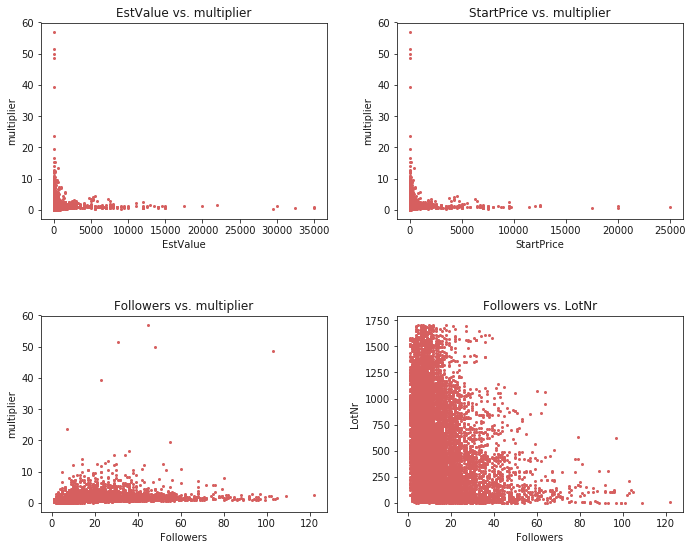

In [52]:
multiple_scatter_plots(df, [('EstValue', 'multiplier'),('StartPrice', 'multiplier'),
                           ('Followers', 'multiplier'),('Followers', 'LotNr')], figsize=(10, 8), 
                       max_row=2)

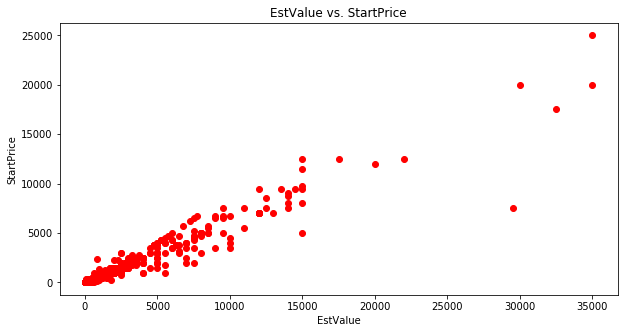

In [8]:
scatter_plot(df, 'EstValue', 'StartPrice')

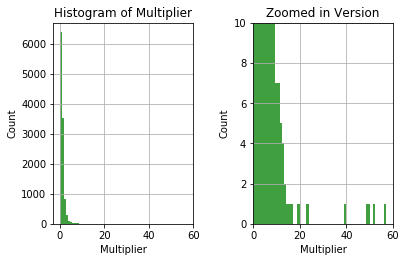

In [9]:
plot_multiplier_distribution()

#### <a name="correlation">4.2 Correlations</a> 
[Back to Table of Contents](#table)

This is where things get really interesting. Why? Because, unfortunately, there is a high correlation between the Estimated Value and the Start Price.   
This basically indicates that the Starting Prices are likely to be a standard percentage of the Estimated Value.   
In other words, we cannot infer how changing the Starting Price would affect the multiplier as it is always the same, which is a **problem**

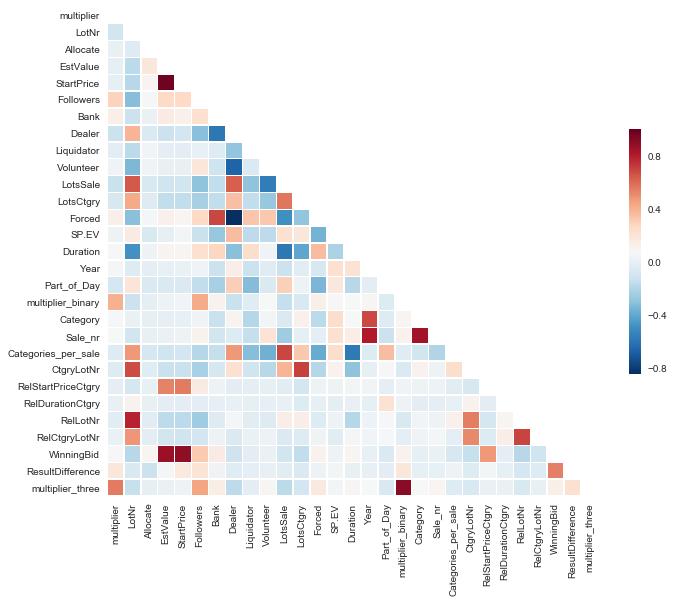

In [11]:
correlation_matrix(df)

In [12]:
corr_matrix = df.corr().abs()
corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), 
                                        k=1).astype(np.bool)).stack().sort_values(ascending=False)
corr_matrix[:10]

EstValue           StartPrice          0.972891
multiplier_binary  multiplier_three    0.909424
StartPrice         WinningBid          0.899354
EstValue           WinningBid          0.871405
Category           Sale_nr             0.852410
Dealer             Forced              0.839268
Year               Sale_nr             0.818900
LotNr              RelLotNr            0.788180
LotsCtgry          CtgryLotNr          0.711148
RelLotNr           RelCtgryLotNr       0.704299
dtype: float64

### <a name="engineering">5. Feature Engineering</a> 
[Back to Table of Contents](#table)

#### <a name="outliers">5.1 Outlier Removal</a> 
[Back to Table of Contents](#table)

As seen before it looks like the target variable 'multiplier' shows some outliers for the multiplier with a value higher than 10. Especially regressors are highly affected by outliers and decrease the resulting score. Therefore, we remove the outliers in this sample. It should be noted that there was no possibility to discuss with the owners of the data as domain expertise would have helped. They could have helped in advising whether to remove the outliers or not and which points to regard as outliers. 

In [13]:
outlier_percentage = len(df[df['multiplier']>10]) / len(df) * 100
print('{} % of outliers with regards to the multiplier'\
      .format(round(outlier_percentage,2)))
df = df[df['multiplier'] <= 10]

0.26 % of outliers with regards to the multiplier


In [14]:
outlier_percentage = len(df[df['EstValue']>=15000]) / len(df) * 100
print('{} % of outliers with regards to the EstValue'\
      .format(round(outlier_percentage,2)))
df = df[df['EstValue'] < 15000]

0.12 % of outliers with regards to the EstValue


Thus, we can clearly see that we removed 0.26% of the outliers when removing all rows that are associated with a multiplier score of higher than 10. 

#### <a name="selectfeatures">5.2 Skewedness</a> 
[Back to Table of Contents](#table)

In order to get a good score out of you regressors you often have to fix a skewed distribution of your feature variables. Regressors in most cases expect a normal distribution that has no skew. Therefore, we would like to do a log(1+p) transform for the variables that show a skew of larger than 0.65. It should be noted though that we only do this for the regression later on as this will not have any effect on 

In [15]:
# df = resolve_skewedness(df)

### <a name="importance">6. Feature Importance</a> 
[Back to Table of Contents](#table)

Here we are going to look into the importance of some features.   
Preferably, we would like to see that important features are those that can be selected as decision variables.  

#### <a name="importancetree">6.1 Decision Tree</a> 
[Back to Table of Contents](#table)

A decision tree is used to give a quick and intuitive feeling on what features are important. 

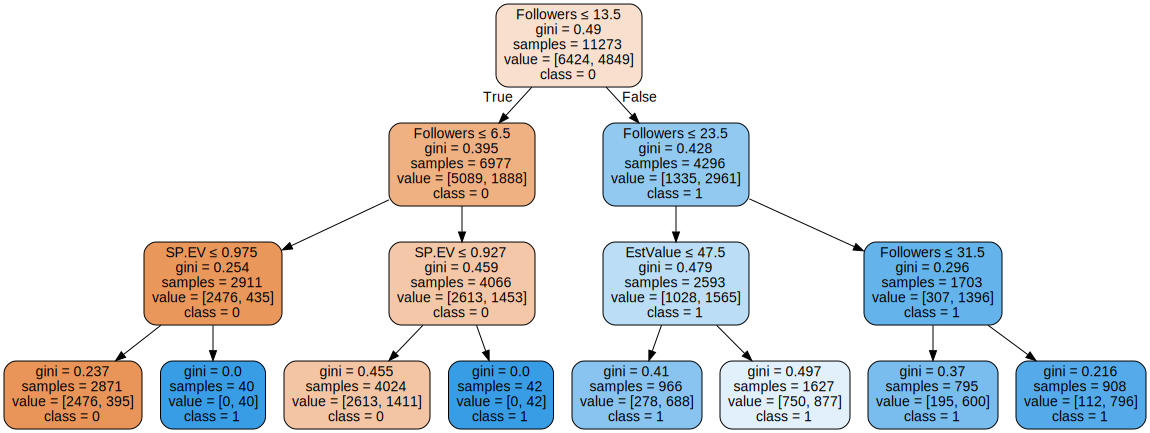

In [16]:
features = ['LotNr','Allocate','EstValue','StartPrice','Followers','Bank','Dealer','Liquidator','Volunteer','LotsSale',
            'LotsCtgry','Forced','SP.EV','Duration','Year','Category','Sale_nr','Categories_per_sale','CtgryLotNr',
            'RelStartPriceCtgry', 'RelLotNr', 'RelCtgryLotNr','RelDurationCtgry']
target = 'multiplier_binary'
dataset, X, y = select_features(df, target = target)
plot_decision_tree(dataset, X, y, max_depth=3)

#### <a name="importanceforest">6.2 Random Forest</a> 
[Back to Table of Contents](#table)

A random forest is a better way of indicating which features are important as it can see for each tree in the forest which features allow for the highest increase/decrease in gini/entropy. 
Unfortunately, Followers is highest and clearly not a decision variable as those are decided beforehand.  
However, **LotNr** seems to be an importance feature and is something we can definitely optimize! 

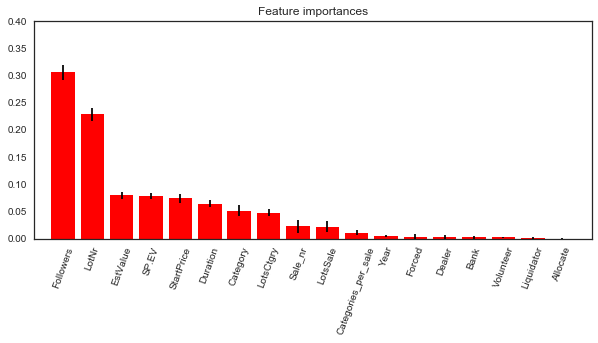

In [17]:
plot_feature_importance(dataset, X, y)

#### <a name="selection">6.3 Feature Selection</a> 
[Back to Table of Contents](#table)

This an important part of most parts that will follow. This piece of code will let you quickly select   
the feature variables that you want in your "X" variable and the target feature variable in "y".   
Moreover, a dataframe called "dataset" will be generated that includes the features and target variables.   
The target variable will always be the last column in dataframe "dataset". 

You can use this code to change the variables in the **Predictions**, **GridSearch** and **Feature Importance**.  

In [18]:
features = ['LotNr','Allocate','EstValue','StartPrice','Followers','Bank','Dealer', 
            'Liquidator','Volunteer','LotsSale','LotsCtgry','Forced','SP.EV', 
            'Duration','Year','Category','Sale_nr','Categories_per_sale','CtgryLotNr',
            'RelStartPriceCtgry', 'RelLotNr', 'RelCtgryLotNr','RelDurationCtgry']
target = 'multiplier_binary'
dataset, X, y = select_features(df, features, target)

### <a name="prediction">7. Prediction</a> 
[Back to Table of Contents](#table)

#### <a name="resultclassifiers">7.1 Classification with K-Fold</a> 
[Back to Table of Contents](#table)

The initial results show that a Random Forest performs best, even with no parameters tweaked.
Some tweaking is ofcourse necessary in order to get the best results.   
It should be noted though that I haven't thought yet
about the best way to do cross validation in this case. For now, it is simply 5-fold cross validation.   
A thought would 
be to use **leave-one out** as we have multiple different sales and we can see how it would perform if we would predict 
for each sale.   
It would definitely most relevant to the optimization as we are (probably) going to optimize individual sales. 

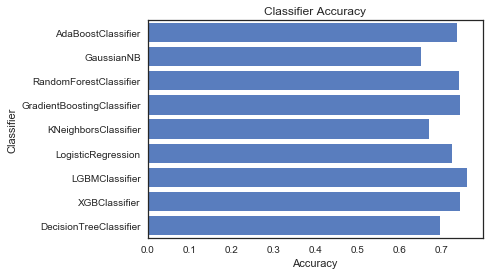

In [67]:
clf = [KNeighborsClassifier(), LGBMClassifier(),DecisionTreeClassifier(),
       RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),
       GaussianNB(),LogisticRegression(),XGBClassifier()]
result = cv_multiple_classifiers(X, y, classifiers = clf, n_splits=10, print_process=False)

#### <a name="loo">7.2 Classification with Leave-One-Out CV</a> 
[Back to Table of Contents](#table)

The issue with normal k-fold cross validation is that there will be leakage of data with respect to individual sales. The purpose of cross validation is to prove that your model works on data that it has not seen before. However, if you use k-fold cross validation then it it likely that information regarding a certain sale will end up in both the train and test sets. Therefore, we adopted leave-one-out (LOO) cross validation which is essentially a k-fold cross validation where the k's are defined by the sales themselves. Seeing as we have 27 sales in the dataset, LOO CV will give us a 27-fold cross validation which is a more accurate than any normal k-fold CV. 

In [68]:
rfc = RandomForestClassifier(n_estimators=100, max_features= 11)
lgbm = LGBMClassifier(learning_rate=0.2, max_depth=2,metric='binary_logloss', min_child_samples=20,min_data_in_leaf=15, num_leaves=2, objective='binary',random_state=42)
xgb = XGBClassifier(gamma=1, learning_rate=0.000001,max_depth=1, min_child_weight=1,n_estimators=100,n_jobs=-1, objective='binary:logistic', random_state=42,reg_alpha=0.5, reg_lambda=0.5)
results, info_folds = loo_cv(dataset, adjust_folds=False, clf=lgbm)

27 folds/sales in the cross validation is fairly large, which is typically not an issue if each fold has enough data. However, there are some folds/sale that only have a few lots in them. What you then get is that you have 99% of the data is trained and only 1% is tested on. When you test on 1% of the data, then it is likely you get outliers, either very high or very low accuracy scores. Therefore, I simply removed the accuracy of folds where the target fold has 50 or less datapoints. 

In [69]:
folds_to_remove = [fold[0]-1 for fold in info_folds.items() if fold[1]<50]
results_new = [value for index, value in enumerate(results) if index not in folds_to_remove]
print('old: {}'.format(sum(results)/len(results)))
print('new: {}'.format(sum(results_new)/len(results_new)))

old: 0.7083953661270547
new: 0.718611468448668


#### <a name="voting">7.3 Voting Classifier with Leave-One-Out CV</a> 
[Back to Table of Contents](#table)

Instead of choosing a single classifier, let's use multiple classifiers and see if they agree on a better model than simply using a single one. The idea is simple, all classifiers make mistakes but they don't all make the same mistakes. It's a principle very similar to Random Forests and ensembles in general. 

In [76]:
clf1 = RandomForestClassifier(n_estimators=100, max_features= 11, random_state=42)
clf2 = AdaBoostClassifier()
clf3 = GradientBoostingClassifier()
clf4 = LGBMClassifier(learning_rate=0.2, max_depth=2,metric='binary_logloss', min_child_samples=20,min_data_in_leaf=15, num_leaves=2, objective='binary',random_state=42)
clf5 = XGBClassifier(gamma=1, learning_rate=0.000001,max_depth=1, min_child_weight=1,n_estimators=100,n_jobs=-1, objective='binary:logistic', random_state=42,reg_alpha=0.5, reg_lambda=0.5)
eclf1 = VotingClassifier(estimators=[('rf', clf1),('ada',clf2),('grad',clf3),('lgbm',clf4),('xgb', clf5)],voting='soft',weights=[1,1,1,3,1])
results, info_folds = loo_cv(dataset, adjust_folds=False, clf=eclf1)

In [77]:
folds_to_remove = [fold[0]-1 for fold in info_folds.items() if fold[1]<50]
results_test = [value for index, value in enumerate(results) if index not in folds_to_remove]
print('old: {}'.format(sum(results)/len(results)))
print('new: {}'.format(sum(results_test)/len(results_test)))

old: 0.7058487953523901
new: 0.7183394071044964


As you can see the VotingClassifier does not improve results. This does not mean that it is not possible to get an improvement with a VotingClassifier, merely that it is very difficult to do so. Setting the right weights might do the trick. However, even if we manage to do so optimization we'll be lengthy computationally due to the ensemble of models. Thus, let's just keep LightGBM as our preferred as it computationally fast and gives a high accuracy. 

#### <a name="regression">7.4 Regression with K-Fold CV</a> 
[Back to Table of Contents](#table)

The next step is obviously to see whether we can do regression instead of classification. The advantage is that you can more accurately predict the multiplier value and therefore increase the performance of optimization. However, this needs to be fairly accurate in order for this to work seeing as most multiplier values are between 0 and 3. Therefore, we would like to have a RMSE of at most 0.5. 

In [47]:
df = resolve_skewedness(df)
target = 'multiplier'
dataset, X, y = select_features(df, features = [], target = target)
models = [GradientBoostingRegressor(), Lasso(),ElasticNet(),KernelRidge(), 
              RandomForestRegressor(), XGBRegressor(), LGBMRegressor()]
result = {name.__class__.__name__: np.mean(rmse_cross_validation(name, X, y)) for name in models}
result

{'ElasticNet': 0.9227761403114669,
 'GradientBoostingRegressor': 0.835459893069204,
 'KernelRidge': 0.8465575195837018,
 'LGBMRegressor': 0.8492899940535616,
 'Lasso': 0.9224493829111007,
 'RandomForestRegressor': 0.9245381147668305,
 'XGBRegressor': 0.8313899573979497}

The results currently show as lowest score 0.83. Removing high multipliers will help with that, but it seems to me that doing so a bit cheating. At some point you are removing valueable information that is needed for when you model data that was not previously seen. 

### <a name="grid">8. Grid Search</a> 
[Back to Table of Contents](#table)

A simple gridsearch that can be used to find the best parameters for the selected classifier.   
However, changing classifier and selecting parameters is a lot of work, so I decided against putting it all into a function. 

#### <a name="gridclassification">8.1 GridSearch Classification</a> 
[Back to Table of Contents](#table)

In [23]:
target = 'multiplier_binary'
dataset, X, y = select_features(df, features = [], target = target)
parameters = [{'n_estimators': [1, 10, 50, 100, 200, 300], 'max_features':np.arange(1, len(dataset.columns)-1, 1)}]
lgbm_grid = {'num_leaves': [2,3],'max_depth': [2],'min_data_in_leaf': [15],'objective': ['binary'],'boosting': ['gbdt'],'metric': ['binary_logloss'],'learning_rate': [0.2]}
xgb_grid = {'max_depth': [1,3], 'learning_rate': [0.0001],'min_child_weight': [1]}
# grid_search(xgb_grid, XGBClassifier())

#### <a name="gridregression">8.2 GridSearch Regression</a> 
[Back to Table of Contents](#table)

In [31]:
param_grid_gradient = {'n_estimators': [500, 3000], 'learning_rate': np.arange(0.01, 0.1, 0.01), 
              'max_depth': [1, 3, 5, 7], 'min_samples_leaf': [10, 15, 20], 'min_samples_split': [10, 15, 20]}
param_grid_lasso = {'alpha':np.arange(0.0001, 0.001, 0.0001), 'max_iter': np.arange(10000, 50000, 10000)}
param_grid_net = {'alpha': np.arange(0.0001, 0.001, 0.0001),'max_iter': np.arange(1000, 10000, 1000)}
param_grid_ridge = {'alpha': np.arange(0.1, 0.9, 0.1),'kernel': ['polynomial'],'degree': [2],'coef0':[1.85]} 
model = [GradientBoostingRegressor(), Lasso(), ElasticNet(), KernelRidge()]
# grid_search(param_grid_gradient, model[0])

### <a name="optimization">9. Optimization - Description</a> 
[Back to Table of Contents](#table)


**Decision Variables:**  
Decision variables are features that we can change before the auction starts in order to optimize the profit made.   
For example, the starting price is a decision variable as we can change what it would be before the auction.   
The estimated value on the other is *not* a decison variable as they are judged by experts and typically do not change.  
  
The following are chosen to be the decision variables:  
* *StartPrice*: starting bidding price of the lot
* *Duration*: duration of auctions in hours on a lot

**Sale Selection**  
For optimization, it might be best to approach it in one of two ways:
* Either leave one sale out and optimize that one, or
* Construct our own sale and try to optimize that one

Leaving one sale out is preferred as it represents real data. We simply leave one out, train on the rest and then simply optimize that sale. 

**Performance**  
The performance of an auction is judged by the sum of all predicted binary multipliers. If there are 10 items that are predicted a 1, then the total score is a 10.   
However, predicting a 1 for an item that is estimated to be worth \$100 is not necessarely the same as predicting a 1 for an item with a worth of \$200.   
You can choose to do a weighted sum of 0's and 1's in order to approximate a regression task. For example, an item worth \$100 with a prediction of 1 might be multiplied by 1.1 whereas the \$200 item is multiplied by 1.2 to indicate that it is more important to score a 1 for a higher valued item than a lower valued item. However, we start by optimizing the number of 1s. 

Thus, there are three possible performance measures:  
* Unweighted Classification 
* Weighted Classification 
* Regression (best way, but difficult to achieve a low RMSE)

We start with regression so indicate to which extend that is possible. As you will see below, it has difficulties limiting the maximum amount of money that can be made. 

**Heuristics**  
We basically have to find the right combination of decision variables for each lot.   
In order to do that we can either brute-force it, which is difficult and might take too much time.   
Or we can choose to use a heuristic for that purpose. 

* Step 1: Insert the LotNr based on Highest Estimated Value
* Step 2: Choose the Duration based on the Duration correlated highest to the Multiplier
* Step 3: ....
* Step 4: Profit! 

### <a name="regressionoptimization">10. Optimization with Regression</a> 
[Back to Table of Contents](#table)

**Fit Data**  
Train on all sales are not sale_nr 10 so we have a pre-trained model on which we can do the optimization

In [19]:
df, to_optimize, baseline, X, y = prepare_data_optimization(target='multiplier')
regressor = GradientBoostingRegressor(n_estimators = 3000, min_samples_leaf = 15, learning_rate = 0.05, max_features ='sqrt',min_samples_split = 10, loss = 'huber').fit(X, y)
regressor = Lasso().fit(X, y)

Let's say I randomly put in some numbers, how well would I do? 

In [20]:
to_optimize.LotNr = range(len(to_optimize), 0, -1)
to_optimize.StartPrice = to_optimize.EstValue * 10000000000
to_optimize.Duration = 50
to_optimize.Part_of_Day = 1

In [21]:
result = int(np.sum(regressor.predict(to_optimize.values) * to_optimize.EstValue.values))
print('Baseline: \t${},-'.format(int(baseline)))
print('Optimization: \t${},-'.format(int(result)))

Baseline: 	$65530,-
Optimization: 	$210216374858014,-


**Problem:**  
Clearly we have a problem, the model apparently thinks that a higher Starting Price leads to a higher multiplier. However, if we set the Starting Price at 10 times the Estimated Value then it gives a high score, while in reality nobody would actually bid that much. Thus, this is an indication of the issues when using a regressor in this case. 
This problem exists for Lasso, Ridge and ElasticNet because they are typical regressors. 

The regressors that seem to work are:
* GradientBoosting
* RandomForestRegressor

### <a name="optimizationfull">11. Optimization - Classification</a> 
[Back to Table of Contents](#table)   

I've chosen the following variables to be decision variables that we can optimize:
* StartPrice
* Duration

#### <a name="geneticalgorithm">11.1 Genetic Algorithm</a> 
[Back to Table of Contents](#table)   

In [3]:
df, to_optimize, baseline, X, y = prepare_data_optimization()
clf = LGBMClassifier(learning_rate=0.2, max_depth=2,metric='binary_logloss', min_child_samples=20,
        min_data_in_leaf=15, num_leaves=2, objective='binary',random_state=42).fit(X, y)

In [4]:
temp_to_optimize = heuristic_ga(to_optimize, target = 'StartPrice', min_val = 0, max_val = 500)

Start of evolution
  Evaluated 300 individuals
-- End of (successful) evolution --


In [6]:
print_results(temp_to_optimize, 'Genetic Algorithm', clf, to_optimize, 'Baseline')

Baseline
Sum of 1s: 193
Sum of probs that class is 1: 134.31452018508756

Genetic Algorithm
Sum of 1s: 217
Sum of probs that class is 1: 155.1691108767212


#### <a name="heuristic">11.2 Heuristic</a> 
[Back to Table of Contents](#table)   
The heuristic optimizes the value of the feature variable (i.e. StartPrice or Duration)
by iterating over values as defined by the interval. Thus,
a starting value is selected and added by the interval until
it improves. If after 10 iterations there has been no improvement,
it resets back to the starting value and goes the other direction. 
For example, if adding 5 to the starting price of 40 doesn't yield 
any improvement, reset back to the starting price of 40 and substract
5 instead.

In [5]:
df, to_optimize_v2, baseline, X, y = prepare_data_optimization()

results = []
for index, row in enumerate(to_optimize_v2.values):
    to_optimize_v2.iloc[index], improvements = heuristic_probabilities(row, feature = 'StartPrice',interval = 1)
    results.append(improvements)

In [6]:
print_results([(to_optimize_v2, 'Heuristic'), (to_optimize, 'Baseline')], clf)

Heuristic
Sum of 1s: 217
Sum of probs that class is 1: 155.51677586136967

Baseline
Sum of 1s: 193
Sum of probs that class is 1: 134.31452018508756



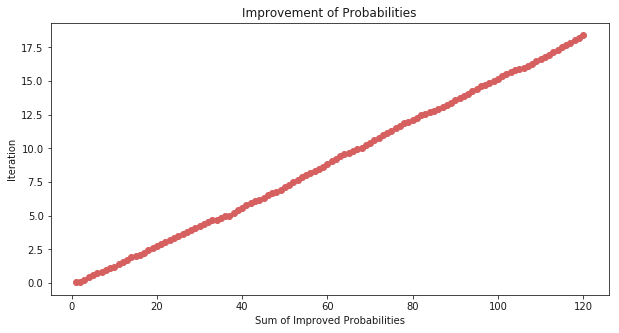

In [92]:
results = [x for y in results for x in y] # Flatten results
results = [(i + 1, sum(results[:i+1])) for i in range(len(results))] # Sum sequence 
results = pd.DataFrame(results, columns = ['index', 'value'])
scatter_plot(results, 'index', 'value', xlabel='Sum of Improved Probabilities', ylabel='Iteration', 
             title='Improvement of Probabilities')

#### <a name="validation">11.3 Validation</a> 
[Back to Table of Contents](#table)   
Our classifier gives ~70% accuracy. In the worst case scenario 30% of classifications are incorrect. Therefore, let's see what happens if change 30% of 0's and 1's to 1's and 0's respectively. 

In [42]:
validate_heuristic_results(clf, to_optimize_v2, baseline, percentage=30, iterations=1000)

Baseline: 	200
Optimization: 	200.172


This is a great result! Why? Because this is the minimum sum that we can achieve assuming in practice it is also 70% accuracy. In practice, it may actually result in a better score. 

Also, there are more 1's after optimization (which is of course the goal) which means that if you are inverting the scores, it is more likely that you would invert a 1 to a 0. Thus, this even further validates that the optimization score is a bare minimum. 